In [31]:
import os
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold


# Prepare dataset

In [32]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True
)

In [33]:
data_dir = os.path.join(os.path.dirname(zip_file), "cora")
print("data location:", data_dir)

data location: /Users/willnguyen/.keras/datasets/cora


In [34]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"]
)
print("citations shape:", citations.shape)

citations shape: (5429, 2)


In [35]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [36]:
paper_feature = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"] # 1433 mean n.o term
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=paper_feature
)
papers.head()

,paper_id,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,...,term_1424,term_1425,term_1426,term_1427,term_1428,term_1429,term_1430,term_1431,term_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [37]:
papers["subject"].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64

In [38]:
class_name = sorted(papers["subject"].unique())
paper_name = sorted(papers["paper_id"].unique())
class_name_mapping_idx = {name:idx for idx, name in enumerate(class_name)}
paper_name_mapping_idx = {name:idx for idx, name in enumerate(paper_name)}
# convert dataframe paper_id and subject into idx
papers["subject"]= papers["subject"].map(class_name_mapping_idx, na_action= "ignore")
papers["paper_id"]= papers["paper_id"].map(paper_name_mapping_idx, na_action= "ignore")
citations["source"]= citations["source"].map(paper_name_mapping_idx, na_action= "ignore")
citations["target"]= citations["target"].map(paper_name_mapping_idx, na_action= "ignore")


In [39]:
citations.head()

,target,source
0,0,21
1,0,905
2,0,906
3,0,1909
4,0,1940


# Base line model

In [52]:
def run_exp(model, x_train, y_train, **kwargs):
    num_epochs = kwargs.get("num_epochs")
    batch_size = kwargs.get("batch_size")
    learning_rate = kwargs.get("learning_rate")
    
    model.compile(
        optimizer= keras.optimizers.Adam(
            learning_rate=learning_rate
        ),
        loss= keras.losses.SparseCategoricalCrossentropy(
            from_logits= True, # have to be True if False model is no longer learning
        ),
        metrics= [
            keras.metrics.SparseCategoricalAccuracy(
                name= "acc"
            ),
        ]
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc",
        patience=50,
        restore_best_weights=True
    )
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size= batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )
    return history

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "val"])
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("loss")
    
    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "val"])
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("acc")
    
    plt.show()
    

In [53]:
def create_ffn(hidden_units, dropout_rate, name=None):
    model_layers= []
    for idx, unit in enumerate(hidden_units):
        model_layers.append(layers.BatchNormalization())
        model_layers.append(layers.Dropout(dropout_rate))
        model_layers.append(layers.Dense(units=unit, activation=tf.nn.gelu))
    
    return keras.Sequential(model_layers, name=name)

def create_baseline_model(hidden_units, num_classes, num_features, dropout_rate = 0.2):
    inputs = layers.Input(shape=(num_features,), name= "input features")
    x = create_ffn(hidden_units, dropout_rate, name= "ffn_block1")(inputs)
    for idx in range(4):
        x1 = create_ffn(hidden_units, dropout_rate, name= f"ffn_block{idx+2}")(x)
        # skip connection
        x = layers.Add(name= f"skip_connection_{idx+1}")([x, x1])
    logits = layers.Dense(num_classes, name="logits")(x)
    
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")
        

In [54]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=3047)
features = sorted(set(paper_feature) - {"paper_id", "subject"})
num_classes = papers["subject"].nunique()
for train_index, test_index in kfold.split(papers[paper_feature], papers["subject"]):
    X_train= papers.loc[train_index][features].to_numpy()
    y_train= papers.loc[train_index]["subject"].to_numpy()
    X_test= papers.loc[test_index][features].to_numpy()
    y_test= papers.loc[test_index]["subject"].to_numpy()
    
    break



In [56]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256
baseline_model = create_baseline_model(
    hidden_units= hidden_units, 
    num_classes= num_classes,
    num_features= len(features),
    dropout_rate= dropout_rate,
)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input features (InputLayer)     [(None, 1433)]       0                                            
__________________________________________________________________________________________________
ffn_block1 (Sequential)         (None, 32)           52804       input features[0][0]             
__________________________________________________________________________________________________
ffn_block2 (Sequential)         (None, 32)           2368        ffn_block1[0][0]                 
__________________________________________________________________________________________________
skip_connection_1 (Add)         (None, 32)           0           ffn_block1[0][0]                 
                                                                 ffn_block2[0][0]          

In [57]:
history = run_exp(
    model= baseline_model,
    x_train= X_train,
    y_train = y_train,
    num_epochs= num_epochs,
    batch_size= batch_size,
    learning_rate= learning_rate,
    
)


Epoch 1/300
5/5 [==============================] - 4s 144ms/step - loss: 3.4370 - acc: 0.1722 - val_loss: 1.8469 - val_acc: 0.3627
Epoch 2/300
5/5 [==============================] - 0s 20ms/step - loss: 2.7317 - acc: 0.2435 - val_loss: 1.8649 - val_acc: 0.2794
Epoch 3/300
5/5 [==============================] - 0s 33ms/step - loss: 2.3246 - acc: 0.2383 - val_loss: 1.8710 - val_acc: 0.4118
Epoch 4/300
5/5 [==============================] - 0s 19ms/step - loss: 2.1041 - acc: 0.2783 - val_loss: 1.8653 - val_acc: 0.4461
Epoch 5/300
5/5 [==============================] - 0s 27ms/step - loss: 1.9818 - acc: 0.2887 - val_loss: 1.8394 - val_acc: 0.4265
Epoch 6/300
5/5 [==============================] - 0s 23ms/step - loss: 1.8056 - acc: 0.3287 - val_loss: 1.8445 - val_acc: 0.3088
Epoch 7/300
5/5 [==============================] - 0s 30ms/step - loss: 1.7457 - acc: 0.3409 - val_loss: 1.8447 - val_acc: 0.2402
Epoch 8/300
5/5 [==============================] - 0s 23ms/step - loss: 1.6668 - acc: 0.3

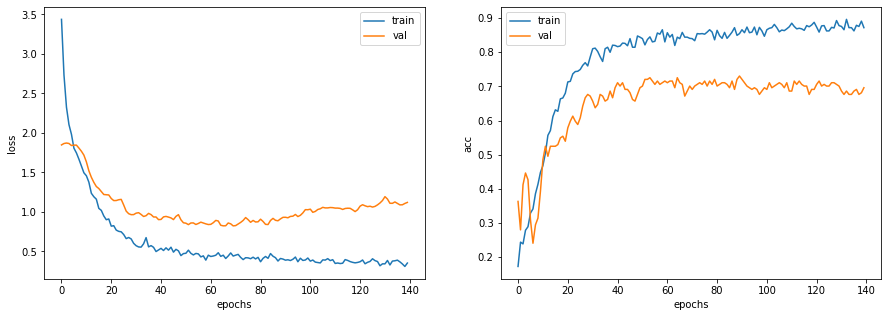

In [58]:
plot_history(history)

In [61]:
test_loss, test_accuracy = baseline_model.evaluate(X_test, y_test)
print("test accuracy:", test_accuracy)

43/43 [==============================] - 0s 2ms/step - loss: 0.8204 - acc: 0.7408
test accuracy: 0.7407680749893188


In [60]:
# layers.Embedding()
# tf.cast()
# tf.expand_dims()
# tf.math.reduce_max()
# tf.math.unsorted_segment_sum()
# tf.gather()